TKET has a lot of nice transpilation passes. Most of the time, the circuits transpiled using TKET passes have lower depth and number of CNOT gates.

This module provides a set of wrappers on those passes so that they can be used in Qiskit.

#### `ToQiskitPass`

To use a TKET pass in Qiskit you can simply pass its class to `ToQiskitPass`

In [1]:
from qiskit_tket_passes import ToQiskitPass
import pytket.passes as tkps

_pass1 = ToQiskitPass(tkps.SynthesiseTket)

# If TKET pass' constructor expects some arguments, pass them after the class name
_pass2 = ToQiskitPass(tkps.FullPeepholeOptimise, allow_swaps=True, target_2qb_gate='cx')

Qiskit passes and TKET passes accept quantum device constraints in different formats. For example, Qiskit passes accept basis gate set as a list of strings, and TKET passes accept it as a `Set` of `pytket.circuit.OpType`s. Another example is `coupling_map`. While we can use a `List[List[int]]` with Qiskit passes, TKET passes expect an instance of `pytket.architecture.Architecture` class.

To overcome this mismatch and make it easy for Qiskit developers to use TKET passes, `ToQiskitPass` accepts both the types.
For example, you can create an instance from `AASRouting` as follows:

In [2]:
from pytket.architecture import Architecture

arc = Architecture([(0, 1), (1, 0), (1, 2), (1, 3), (2, 1), (3, 1), (3, 4), (4, 3)])
_pass = ToQiskitPass(tkps.AASRouting, arc=arc)

You can also follow Qiskit's style and pass it as `List[List[int]]`:

In [3]:
_pass = ToQiskitPass(tkps.AASRouting, arc=[[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]])

Moreover, ToQiskitPass accepts a `Target` instance. And if `arc` argument is missing, it tries to get its value from target:

In [4]:
from qiskit.providers.fake_provider import FakeQuitoV2

backend = FakeQuitoV2()
_pass = ToQiskitPass(tkps.AASRouting, target=backend.target)

print(_pass.tket_argument('arc').to_dict())

{'links': [{'link': [['node', [3]], ['node', [4]]], 'weight': 1}, {'link': [['node', [4]], ['node', [3]]], 'weight': 1}, {'link': [['node', [1]], ['node', [3]]], 'weight': 1}, {'link': [['node', [3]], ['node', [1]]], 'weight': 1}, {'link': [['node', [1]], ['node', [2]]], 'weight': 1}, {'link': [['node', [2]], ['node', [1]]], 'weight': 1}, {'link': [['node', [0]], ['node', [1]]], 'weight': 1}, {'link': [['node', [1]], ['node', [0]]], 'weight': 1}], 'nodes': [['node', [3]], ['node', [4]], ['node', [1]], ['node', [2]], ['node', [0]]]}


##### Supported argument types:
 - pytket.architecture.Architecture
    > Get value from `Target` object.
 - pytket.circuit.Circuit:
   > Accepts Qiskit's `QuantumCircuit`
 - pytket.circuit.OpType
    > Accepts `str` value. e.g., `cx`
 - Set[pytket.circuit.OpType]
     > Accepts list of strings. e.g., `['cx', 'id', 'rz', 'sx', 'x']`
 - pytket.transform.CXConfigType
   > Accepts `str` value. e.g., `Snake`
 - pytket.transform.PauliSynthStrat
   > Accepts `str` value. e.g., `Sets`
 - pytket.placement.Placement
   > Accepts `str` value. e.g., `Graph`. If missing, creates a `NoiseAwarePlacement` based on backend info in `Target` object.

#### `TketPassManager`

pytket-qiskit is an extension which allows us among other things to use IBM quantum devices and Qiskit Aer simulators with TKET. And defines the proper combination of TKET passes that should be used to transpile a quantum circuit so that it can run on them. `TketPassManager` encapsulates this combination of TKET passes so that Qiskit developers can easily use TKET passes to do the whole transpilation process.

In [5]:
from qiskit.circuit.random import random_circuit
from pytket.extensions.qiskit import AerBackend
from qiskit_tket_passes import TketPassManager

qc = random_circuit(3, 10, seed=1)
pm = TketPassManager(AerBackend(), optimization_level=2)
transpiled_qc = pm.run(qc)

#### Transpiler Stage Plugins

`ToQiskitPass` allows us to insert individual TKET passes into the transpilation process with other Qiskit passes, and `TketPassManager` makes it easy to fully transpile a circuit using TKET passes only. Can have something in between?

Transpilation process in Qiskit is divided into a set of stages, such as `routing`, `translation`, and `optimization`. Can we have an easy way to use TKET passes to cover one of these stages? 

Qiskit 0.39 introduced a plugin interface for transpiler stages that can be used to enable alternative `PassManager` objects from an external package in a particular stage for the preset pass managers and the `transpile()` function.

Our module comes with a set of plugins that cover most the stages of transpilation process and support both Aer simulators and IBM Quantum devices.

You can use them, as any other transpiler stage plugin, by passing the plugin name to `transpile()` function. As an example, to use TKET passes in `translation` stage we set `translation_method` to `'tket'` as follows

```
circ = transpile(circ, backend=backend, optimization_level=3, translation_method='tket')
```

#### Transpiling Qiskit circuits using TKET passes

Now, let's try TKET passes. We begin by creating a random circuit

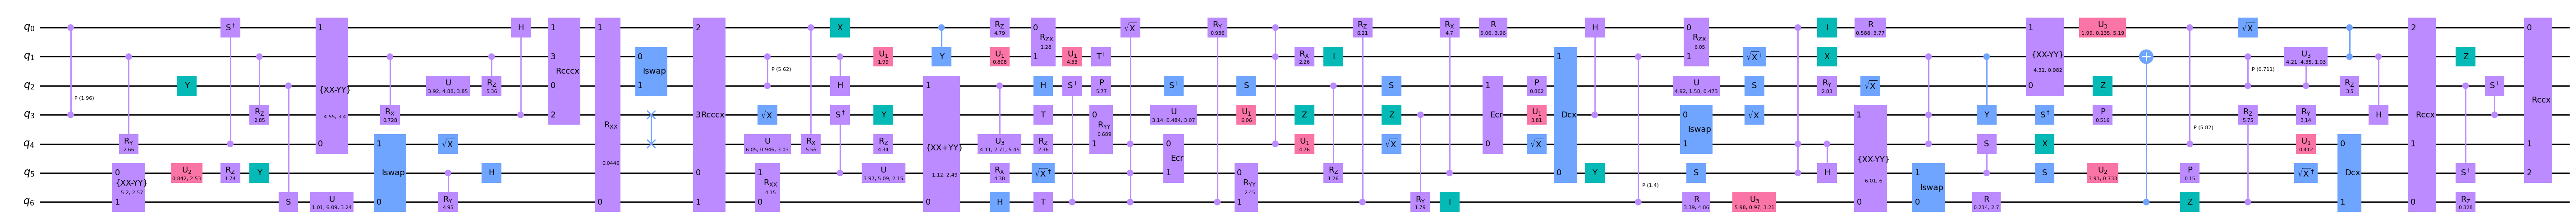

In [6]:
from qiskit.circuit.random import random_circuit

circ = random_circuit(7, 30, seed=1)
circ.draw('mpl', fold=-1)

We take a custom pass manager defined in [Qiskit documentation](https://qiskit.org/documentation/apidoc/transpiler.html#custom-pass-managers) and use it to transpile the circuit.

In [8]:
from qiskit.transpiler.passes import (
    UnitarySynthesis,
    Collect2qBlocks,
    ConsolidateBlocks,
    Unroll3qOrMore,
)
from qiskit.transpiler import PassManager, StagedPassManager

basis_gates = ["rx", "ry", "rxx"]
init = PassManager([UnitarySynthesis(basis_gates, min_qubits=3), Unroll3qOrMore()])
translate = PassManager(
    [
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates=basis_gates),
        UnitarySynthesis(basis_gates),
    ]
)

staged_pm = StagedPassManager(
    stages=["init", "translation"], init=init, translation=translate
)

In [9]:
tr_circ = staged_pm.run(circ)
print('Depth:', tr_circ.depth())

Depth: 446


Now, we add one of the TKET optimization passes to the pass manager and re-transpile the circuit

In [10]:
optimize = PassManager(
    [
        ToQiskitPass(tkps.RemoveRedundancies)
    ]
)

staged_pm = StagedPassManager(
    stages=["init", "translation", "optimization"], init=init, translation=translate, optimization=optimize
)

In [11]:
tr_circ = staged_pm.run(circ)
print('Depth:', tr_circ.depth())

Depth: 405


Let's now transpile our circuit using `TketPassManager`

In [12]:
from pytket.extensions.qiskit import IBMQBackend
from qiskit_tket_passes import TketPassManager

qbackend = IBMQBackend('ibmq_jakarta')

In [15]:
pm = TketPassManager(qbackend, optimization_level=2)
#pm.draw()

In [16]:
tr_circ = pm.run(circ)
print('CNOTs:', tr_circ.count_ops()['cx'])
print('Depth:', tr_circ.depth())

CNOTs: 276
Depth: 418


For comparison, we transpile this circuit using Qiskit transpiler

In [17]:
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider()
backend = provider.get_backend('ibmq_jakarta')

In [18]:
from qiskit import transpile

tr_circ = transpile(circ, backend=backend, optimization_level=3)
print('CNOTs:', tr_circ.count_ops()['cx'])
print('Depth:', tr_circ.depth())

CNOTs: 311
Depth: 452


We can easily see that, using TKET's default transpilation passes gives us lower circuit depth and less
number of two qubit gates.

Finally, we try the transpiler stage plugins

In [22]:

print('init:')
circ_init = transpile(circ, backend=backend, optimization_level=3, init_method='tket')
print('CNOTs:', circ_init.count_ops()['cx'])
print('Depth:', circ_init.depth())

print('\ntranslation:')
circ_trans = transpile(circ, backend=backend, optimization_level=3, translation_method='tket')
print('CNOTs:', circ_trans.count_ops()['cx'])
print('Depth:', circ_trans.depth())

print('\noptimization:')
circ_opt = transpile(circ, backend=backend, optimization_level=3, optimization_method='tket')
print('CNOTs:', circ_opt.count_ops()['cx'])
print('Depth:', circ_opt.depth())


init:
CNOTs: 309
Depth: 435

translation:
CNOTs: 311
Depth: 462

optimization:
CNOTs: 298
Depth: 418


And of course, you can apply multiple `tket` plugins at the same time

In [23]:
from colorama import Fore, Style

def _callback(pass_, dag, time, property_set, count):
    is_tket_pass = pass_.name().startswith('TketPass_')
    print(Fore.GREEN if is_tket_pass else Fore.WHITE, pass_.name())
    Style.RESET_ALL

circ_layout = transpile(circ, backend=backend, optimization_level=3,
    init_method='tket',
    translation_method='tket',
    optimization_method='tket',
    callback=_callback)

 ContainsInstruction
 TketPass_DecomposeBoxes
 TketPass_SynthesiseTket
 RemoveResetInZeroState
 OptimizeSwapBeforeMeasure
 RemoveDiagonalGatesBeforeMeasure
 SetLayout
 VF2Layout
 BarrierBeforeFinalMeasurements
 SabreLayout
 CheckMap
 VF2PostLayout
 TketPass_RebaseCustom
 RemoveResetInZeroState
 TketPass_KAKDecomposition
 TketPass_CliffordSimp
 TketPass_CXMappingPass
 TketPass_SynthesiseTket
 TketPass_RebaseCustom
 TketPass_RemoveRedundancies
 TketPass_SimplifyInitial
 ContainsInstruction
 InstructionDurationCheck
 ValidatePulseGates
